In [1]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json, pformat, pformat_vars
from itertools import product, combinations
# import pyperclip
import random
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.templating import FixedTemplate, SimpleTemplater
# from causalbenchmark.novo.verbalization import misc
from causalbenchmark import misc
from causalbenchmark.verbalization.decision import Decision
from causalbenchmark.templating import Template
from causalbenchmark.verbalization import Verbalizer, MarginalVerbalization, ConditionalVerbalization
from causalbenchmark.verbalization.variable import VariableVerbalization
from causalbenchmark.verbalization.flavors import PrecisePercent
from causalbenchmark.seeding.prompting import VerbalizationPrompting
from causalbenchmark.simulation.solvers import ATE_Sign

In [2]:
path = misc.data_root() / 'stories'
story_names = [p.stem for p in path.glob('*.json')]#[:1]
print(story_names)

['Impact_of_Extreme_Weather_on_JR_Kyudai_Line_Operations', "Larisa Kuklina's Performance and Injury Analysis", 'Ozone_Recovery_and_Climate_Change_Impact', 'Impact_of_COVID-19_on_Australian_CO2_Emissions', 'Analyzing_the_Impact_of_Moon_New_Deal_Fund', 'Impact_of_SCGP_Deltalab_Acquisition_on_Revenue_Trends', 'Impact_of_Covid_on_Auto_Industry_Job_Market', 'Cross-Border Aid Response Analysis - Nowa Biała Fire Incident', 'Electra_SolarEnergyVenture_ImpactAnalysis', 'Evolving_Tech_Trends_and_Adoption_Rates_2021', "Impact of Climate Change on Moose Calves' Growth", 'BelGee_Geely_Car_Production_Analysis', 'Impact_of_FDA_Menthol_Ban_on_Cigarette_Sales_and_Public_Health', 'Impact_of_Vrbetice_Compensation_on_Local_Economies_and_Living_Standards', "Examining the Flight of Success - Analyzing Emirates Airlines' Safety Achievements", 'Trend_Analysis_of_Retail_Sector_Lawsuits', 'Effectiveness_of_HPV_Self-Testing_in_Māori_Pasifika_Asian_Communities', "Exploring_the_Impact_of_Blue_Light_on_Earth's_Gree

In [3]:
use_old_loading = False
# story_names = [
# 	# 'old/test19', 'old/test20', 'old/test21',
# 	# 'Facebook-WallStreet_Trends_Post-Verdict1',
# 	# 'RoyalFashionTrends_Analysis2',
# 	# 'EU Gas Alliance and Inflation Trends',
# 	
# 	'Impact_of_Covid_on_Auto_Industry_Job_Market',
# 	
# ]
stories = []
for name in story_names:
	story = Story(story_root=misc.data_root() / 'stories', story_id=name)#.populate_defaults()
	stories.append(story)
	if use_old_loading:
		story['stats'] = {int(k): v for k, v in story['stats'].items()}
		story['verbs'] = {k: {int(k2): v2 for k2, v2 in v.items()} for k, v in story['verbs'].items()}
		for k, v in story['verbs'].items():
			for k2, v2 in v.items():
				if 'value' in v2:
					v2['value'] = {int(k3): v3 for k3, v3 in v2['value'].items()}
		story['questions']['questions'] = {int(k): v for k, v in story['questions']['questions'].items()}
len(stories)

In [4]:
def old_story_atoms(story):
	varverbs = {}
	for var, raw in story['verbs'].items():
		info = {'values': {0: {}, 1: {}}}
		
		info['variable'] = raw[1]['variable']
		info['subject'] = raw[2]['subject']
		info['domain'] = raw[4]['domain']
		
		for i in [0, 1]:
			info_val = info['values'][i]
			info_val['verb'] = raw[2]['value'][i] # goes with subject
			info_val['phrase'] = raw[3]['value'][i]
			info_val['descriptor'] = raw[4]['value'][i] # goes with domain
			info_val['event'] = raw[5]['value'][i]
			info_val['conditional'] = raw[6]['value'][i]
			info_val['interventional'] = raw[7]['value'][i]
			
		varverbs[var] = info
	
	story['sheet'] = varverbs
	return story

def story_atoms(story):
	base_keys = ['descriptor', 'subject', 'pronoun', 'preposition', 'domain']
	value_keys = ['predicate', 'nounclause', 'subclause', 'condition', 'action']
	verbs = []
	for node in story['nodes']:
		try:
			raw = story['verbs'][node['name']]
		except:
			print(story['motivation']['title'])
			raise
		info = {'values': {0: {}, 1: {}}}
		info.update({key: raw[key] for key in base_keys})
		for i in [0, 1]:
			info_val = info['values'][i]
			info_val.update({key: raw[f'{key}{i}'] for key in value_keys})
		# node['verbs'] = info
		verbs.append(info)
	story['verbs'] = verbs
for story in stories:
	(old_story_atoms if use_old_loading else story_atoms)(story)

In [5]:
story = random.choice(stories)
# story = stories[4]
# rawverbs = story['verbs']
# rawvars = {node['name']: node for node in story['nodes']}
# next(iter(rawverbs.values()))

In [6]:
story['nodes']

[{'name': 'Economic_Activity',
  'description': 'Overall economic activity in Australia',
  'type': 'confounder',
  'observed': True,
  'values': ['Low activity', 'High activity'],
  'parents': []},
 {'name': 'Public_Awareness_of_Environmental_Issues',
  'description': 'Level of public awareness and concern about environmental issues',
  'type': 'treatment',
  'observed': True,
  'values': ['Low awareness', 'High awareness'],
  'parents': ['Economic_Activity']},
 {'name': 'Technological_Advancements',
  'description': 'Advancements in technology related to energy and transportation',
  'type': 'confounder',
  'observed': True,
  'values': ['No advancements', 'Significant advancements'],
  'parents': []},
 {'name': 'COVID-19_Restrictions',
  'description': 'Implementation of restrictions due to the COVID-19 pandemic',
  'type': 'treatment',
  'observed': True,
  'values': ['No restrictions', 'Restrictions implemented'],
  'parents': ['Economic_Activity', 'Technological_Advancements']},


In [6]:
node = random.choice(list(story['nodes']))
varval = 0
node['name'], node['values'][varval]

('Public Demand for Cars', 'Low demand')

In [10]:
def get_varverb(node, verb, varval, **static):
	varverb = VariableVerbalization().populate_defaults().populate_variable({**node, **static}, verb, varval)
	return varverb

def sample_text(ident=None, *other_tools, **static):
	if ident is None:
		ident = {}
	story_id = ident.setdefault('story_id', random.randint(0,len(stories)-1))
	story = stories[story_id]
	
	var_id = ident.setdefault('var_id', random.randint(0,len(story['nodes'])-1))
	# varname = story['nodes'][var_id]['name']
	varval = ident.setdefault('value_id', random.choice([0, 1]))
	
	varverb = get_varverb(story['nodes'][var_id], story['verbs'][var_id], varval, **static)

	conditions = []
	
	parent_ids = {key: val for key, val in sorted(ident.items()) if key.startswith('parent_id')}
	if len(parent_ids) or ident.setdefault('num_parents', random.choice([0, 1, 2])):
		parent_idx_options = [i for i, node in enumerate(story['nodes']) if i != var_id]
		if not len(parent_ids):
			num = ident.setdefault('num_parents', random.choice([0, 1, 2]))
			parent_ids = {f'parent_id{i}': pid for i, pid in enumerate(random.sample(parent_idx_options, k=num))}
		
		pvals = ident.setdefault('parent_vals', [random.randint(0, 1) for _ in range(len(parent_ids))])
		ident['parent_vals'] = tuple(pvals)
		conditions = [get_varverb(story['nodes'][pid], story['verbs'][pid], pval) 
					  for (key, pid), pval in zip(parent_ids.items(), pvals)]
		for k, pid in parent_ids.items():
			ident[k] = pid
	
	verbalizer = Verbalizer().populate_defaults().set_variable(varverb, *conditions)
	verbalizer.extend(other_tools)
	verbalizer.update(ident)
	return verbalizer

In [11]:
samples = []

prior = {
	# 'story_id': 0,
	# 'var_id': 5,
	# 'value_id': 0,
	
	# 'clause_id': 0,
	# 'position_id': 3,
	
	# 'num_parents': 0,
	# 'parent_id1': 0,
	# 'parent_vals': [1],
	# 'parent_id2': 1,
	
}

others = [PrecisePercent()]

for _ in range(30):
	ident = prior.copy()
	ctx = sample_text(ident, *others, mean=0.12)
	text = ctx['sentence']
	ident.update(ctx.identity())
	ctx['ident'] = ident
	samples.append(ctx)

cols = []
for row in samples:
	for key in row['ident']:
		if key not in cols:
			cols.append(key)

table = [(
	# i, len([k for k in row['ident'] if k not in prior]),
		  row['sentence'], 
		  # row['ctx']['event'], row['ctx']['event'], row['ctx']['phrase'], row['ctx']['subject'], row['ctx']['verb'],  
		  # *[row['ident'].get(key, '-') for key in cols]
		  ) for i, row in enumerate(samples)]
print(tabulate(table, headers=['i', 'dof', 'text', *cols]))# *list(map(str, range(len(cols))))]))

i
------------------------------------------------------------------------------------------------------------------------------------------------------------
If athletes are in the younger bracket and athletes resort to doping, 12% of the time athletes regularly monitor their health.
The probability that people experience a low financial burden is 12%.
With a confidence of 12%, investment is approached cautiously.
The likelihood that there is high investment in rail infrastructure is 12%, provided that trains run smoothly and a wet climate dominates.
With a certainty of 12%, there's a lower than usual rise in costs.
Among 12% of global markets, economic conditions are robust.
With a confidence of 12%, investor sentiment towards SCGP is optimistic.
With a confidence of 12%, the blue light is observed.
When staff strictly adhere to safety measures, there is a 12% probability that the airline falls short in effective safety protocol implementation.
In 12% of the sector, rivalry among com

In [12]:
sample = samples[0]
ident = sample['ident']
text = sample['sentence']

print(text)
print(ident)

If athletes are in the younger bracket and athletes resort to doping, 12% of the time athletes regularly monitor their health.
{'story_id': 20, 'var_id': 5, 'value_id': 1, 'num_parents': 2, 'parent_vals': (0, 1), 'parent_id0': 2, 'parent_id1': 3, 'marginal_id': 2, 'antecedent_id': 1, 'cond_conjunction_id': 0, 'conditional_id': 0, 'clause_id': 1, 'nounclause_id': 0}


In [13]:
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(story['stats'])
lower_bound, upper_bound = prob_ranges.t()

net = BernoulliNetwork({node['name']: node['parents'] for node in story['nodes']})

param_sample = torch.rand(len(prob_ranges)) * (upper_bound - lower_bound) + lower_bound
param_sample.requires_grad_(True)
net.set_params(param_sample)

ValueError: Could not save to JPEG for display

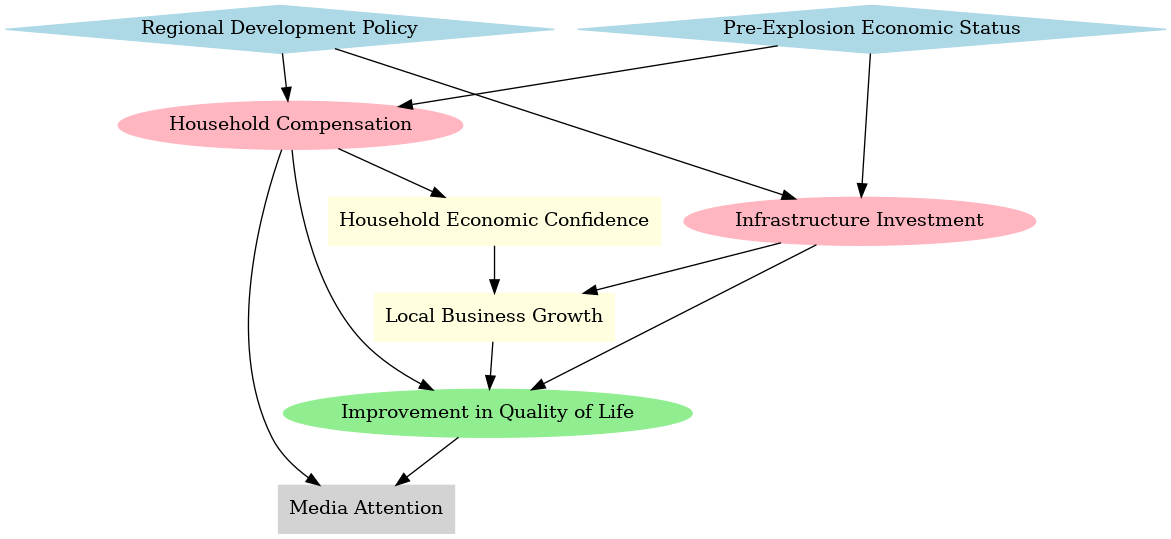

In [14]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in story['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in story['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [15]:
treatments = [v['name'] for v in story['nodes'] if v['type'] == 'treatment']
treatment = treatments[0]
outcome = [v['name'] for v in story['nodes'] if v['type'] == 'outcome'][0]
treatments, outcome

(['Household Compensation', 'Infrastructure Investment'],
 'Improvement in Quality of Life')

In [16]:
len(net.ate_terms(treatments[0], outcome))

In [ ]:
from scipy.optimize import minimize

In [30]:
est = net.marginals()[outcome]

est


tensor(0.4949)

In [42]:
model = net.to_dowhy(treatment, outcome)
model = net.to_dowhy('Regional Sea Ice Levels', outcome)

In [47]:
identified_estimand_nde = model.identify_effect(estimand_type="nonparametric-cde",
                                            proceed_when_unidentifiable=True)
print(identified_estimand_nde)

Estimand type: EstimandType.NONPARAMETRIC_CDE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[Penguin Population Health|Conservation Efforts,Cl
d[Regional Sea Ice Levels]                                                    

                                                 
imate Change Intensity,Penguin Breeding Success])
                                                 
Estimand assumption 1, Unconfoundedness: If U→{Regional Sea Ice Levels} and U→Penguin Population Health then P(Penguin Population Health|Regional Sea Ice Levels,Conservation Efforts,Climate Change Intensity,Penguin Breeding Success,U) = P(Penguin Population Health|Regional Sea Ice Levels,Conservation Efforts,Climate Change Intensity,Penguin Breeding Success)


In [20]:
treatment = treatments[0]

In [21]:
net.marginals()[outcome]

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


tensor(0.4759)

In [25]:
net.vars

[p(Marketing Intensity=0.45),
 p(Environmental Awareness=0.63),
 p(Disposable Income=0.51),
 p(E-bike Price Reduction | Environmental Awareness, Disposable Income),
 p(Consumer Interest in E-bikes | Environmental Awareness),
 p(Retailer Stock Availability | Disposable Income),
 p(E-bike Popularity Increase | E-bike Price Reduction, Marketing Intensity, Consumer Interest in E-bikes, Retailer Stock Availability),
 p(Social Media Engagement | E-bike Popularity Increase, Marketing Intensity)]

In [12]:
net.marginals(**{treatment: 0})[outcome], net.marginals(**{treatment: 1})[outcome]

(tensor(0.3863), tensor(0.5006))

In [13]:
net.marginals(**{treatment: 0, outcome: 0})['Social Media Engagement'], net.marginals(**{treatment: 1, outcome: 0})['Social Media Engagement'], net.marginals(**{treatment: 0, outcome: 1})['Social Media Engagement'], net.marginals(**{treatment: 1, outcome: 1})['Social Media Engagement']

(tensor(0.3685), tensor(0.9691), tensor(0.5848), tensor(0.5853))

In [14]:
net.ate(treatment)[outcome]

/home/fleeb/workspace/code/cladder/causalbenchmark/novo/simulation/models.py:197: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probs = torch.tensor(probs).float()


tensor(0.1218)

In [15]:
neti1 = net.intervene(**{treatment: 1})
neti0 = net.intervene(**{treatment: 0})

In [16]:
neti1.marginals()[outcome], neti0.marginals()[outcome]

(tensor(0.4392), tensor(0.3174))

In [17]:
net.marginals(**{treatment: 1})[outcome], net.marginals(**{treatment: 0})[outcome]

(tensor(0.5006), tensor(0.3863))

In [18]:
neti1.marginals(**{treatment: 1})[outcome], neti0.marginals(**{treatment: 0})[outcome]

(tensor(0.4392), tensor(0.3174))

In [24]:
neti1.marginals()[outcome], neti0.marginals()[outcome]

(tensor(0.4392), tensor(0.3174))

In [19]:
neti1.vars[-2].parents

[p(E-bike Price Reduction | Environmental Awareness, Disposable Income),
 p(Marketing Intensity=1),
 p(Consumer Interest in E-bikes | Environmental Awareness),
 p(Retailer Stock Availability | Disposable Income)]

In [20]:
net.vars[-2].param

tensor([[[[0.1575, 0.2312],
          [0.2334, 0.3272]],

         [[0.2839, 0.3882],
          [0.3650, 0.4809]]],


        [[[0.3339, 0.4676],
          [0.4323, 0.5058]],

         [[0.4116, 0.5943],
          [0.5307, 0.6017]]]])

In [21]:
net.get_params()

tensor([0.5866, 0.4134, 0.4176, 0.5824, 0.4669, 0.5331, 0.7846, 0.2154, 0.6404,
        0.3596, 0.5293, 0.4707, 0.3829, 0.6171, 0.6768, 0.3232, 0.3994, 0.6006,
        0.7866, 0.2134, 0.3695, 0.6305, 0.8425, 0.1575, 0.7688, 0.2312, 0.7666,
        0.2334, 0.6728, 0.3272, 0.7161, 0.2839, 0.6118, 0.3882, 0.6350, 0.3650,
        0.5191, 0.4809, 0.6661, 0.3339, 0.5324, 0.4676, 0.5677, 0.4323, 0.4942,
        0.5058, 0.5884, 0.4116, 0.4057, 0.5943, 0.4693, 0.5307, 0.3983, 0.6017,
        0.7258, 0.2742, 0.6448, 0.3552, 0.5375, 0.4625, 0.4810, 0.5190])

In [22]:
neti0.get_params()

tensor([1.0000, 0.0000, 0.4176, 0.5824, 0.4669, 0.5331, 0.7846, 0.2154, 0.6404,
        0.3596, 0.5293, 0.4707, 0.3829, 0.6171, 0.6768, 0.3232, 0.3994, 0.6006,
        0.7866, 0.2134, 0.3695, 0.6305, 0.8425, 0.1575, 0.7688, 0.2312, 0.7666,
        0.2334, 0.6728, 0.3272, 0.7161, 0.2839, 0.6118, 0.3882, 0.6350, 0.3650,
        0.5191, 0.4809, 0.6661, 0.3339, 0.5324, 0.4676, 0.5677, 0.4323, 0.4942,
        0.5058, 0.5884, 0.4116, 0.4057, 0.5943, 0.4693, 0.5307, 0.3983, 0.6017,
        0.7258, 0.2742, 0.6448, 0.3552, 0.5375, 0.4625, 0.4810, 0.5190])

In [23]:
neti1.get_params()

tensor([0.0000, 1.0000, 0.4176, 0.5824, 0.4669, 0.5331, 0.7846, 0.2154, 0.6404,
        0.3596, 0.5293, 0.4707, 0.3829, 0.6171, 0.6768, 0.3232, 0.3994, 0.6006,
        0.7866, 0.2134, 0.3695, 0.6305, 0.8425, 0.1575, 0.7688, 0.2312, 0.7666,
        0.2334, 0.6728, 0.3272, 0.7161, 0.2839, 0.6118, 0.3882, 0.6350, 0.3650,
        0.5191, 0.4809, 0.6661, 0.3339, 0.5324, 0.4676, 0.5677, 0.4323, 0.4942,
        0.5058, 0.5884, 0.4116, 0.4057, 0.5943, 0.4693, 0.5307, 0.3983, 0.6017,
        0.7258, 0.2742, 0.6448, 0.3552, 0.5375, 0.4625, 0.4810, 0.5190])

In [140]:
neti1

p(Social Media Engagement | E-bike Popularity Increase, Marketing Intensity) p(E-bike Popularity Increase | E-bike Price Reduction, Marketing Intensity, Consumer Interest in E-bikes, Retailer Stock Availability) p(Retailer Stock Availability | Disposable Income) p(Consumer Interest in E-bikes | Environmental Awareness) p(E-bike Price Reduction | Environmental Awareness, Disposable Income) p(Disposable Income=0.56) p(Environmental Awareness=0.66) p(Marketing Intensity=1)

In [141]:
net

p(Social Media Engagement | E-bike Popularity Increase, Marketing Intensity) p(E-bike Popularity Increase | E-bike Price Reduction, Marketing Intensity, Consumer Interest in E-bikes, Retailer Stock Availability) p(Retailer Stock Availability | Disposable Income) p(Consumer Interest in E-bikes | Environmental Awareness) p(E-bike Price Reduction | Environmental Awareness, Disposable Income) p(Disposable Income=0.56) p(Environmental Awareness=0.66) p(Marketing Intensity=0.5)

In [111]:
v = net.vars[-2]
v

p(E-bike Popularity Increase | E-bike Price Reduction, Marketing Intensity, Consumer Interest in E-bikes, Retailer Stock Availability)

In [112]:
v.param

tensor([[[[0.1751, 0.2284],
          [0.2776, 0.3487]],

         [[0.2671, 0.3859],
          [0.3427, 0.4144]]],


        [[[0.3868, 0.4330],
          [0.4825, 0.5073]],

         [[0.4173, 0.5699],
          [0.5260, 0.6236]]]])

In [113]:
qid = random.randint(0, len(story['questions'])-1)
qid = 0
question = story['questions'][qid]
query = story['queries'][qid]
question, query

({'question': 'Does increasing marketing efforts for e-bike sales not lead to a rise in their popularity?',
  'answer': 'yes',
  'explanation': 'Intensifying marketing activities does not result in greater popularity of e-bikes.'},
 {'treatment': 'Marketing Intensity',
  'query': 'ate',
  'type': 'ate-sign',
  'criterion': '<'})

In [114]:
solver = ATE_Sign(net)
sol = Context().include(solver)
sol['outcome'] = outcome
sol.update(**query)

In [115]:
sol['estimand']

('Marketing Intensity', 'E-bike Popularity Increase', [])

In [116]:
sol['terms']

[('E-bike Popularity Increase', {'Marketing Intensity': 0}),
 ('E-bike Popularity Increase', {'Marketing Intensity': 1})]

In [117]:
sol['ate']

In [118]:
sol['estimate']

/home/fleeb/miniconda3/lib/python3.11/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


In [32]:
net.ate(query['treatment'], conditions={query['confounder']: query['confounder_value']})[outcome]

tensor(0.0290)

In [ ]:
net.ate(query['treatment'], conditions={query['confounder']: query['confounder_value']})[outcome]

In [42]:
print(VerbalizationPrompting().get_query_descriptions(story['queries']))

	1. ATE('Meteorite Visibility') < 0
	2. ATE('NASA Communication') < 0
	3. ATE('Meteorite Visibility') > ATE('NASA Communication')
	4. |ATE('Meteorite Visibility')| < |ATE('NASA Communication')|
	5. CATE('Meteorite Visibility' | 'Media Coverage' = 0) < 0
	6. CATE('NASA Communication' | 'Media Coverage' = 0) < 0
	7. CATE('Meteorite Visibility' | 'Media Coverage' = 0) > CATE('NASA Communication' | 'Media Coverage' = 0)
	8. |CATE('NASA Communication' | 'Media Coverage' = 0)| < |CATE('Meteorite Visibility' | 'Media Coverage' = 0)|
	9. CATE('Meteorite Visibility' | 'Media Coverage' = 1) < 0
	10. CATE('NASA Communication' | 'Media Coverage' = 1) < 0
	11. CATE('Meteorite Visibility' | 'Media Coverage' = 1) < CATE('NASA Communication' | 'Media Coverage' = 1)
	12. |CATE('NASA Communication' | 'Media Coverage' = 1)| > |CATE('Meteorite Visibility' | 'Media Coverage' = 1)|
	13. CATE('Meteorite Visibility' | 'Media Coverage' = 1) < CATE('Meteorite Visibility' | 'Media Coverage' = 0)
	14. |CATE('Mete

In [ ]:
ident = {}
ctx = sample_text(ident, mean=0.57)



text = Template.detok(ctx['clause'], capitalize=True, sentence=True)
ident.update(ctx.identity())
print(text)
ident

In [33]:

selection = {}




story = random.choice(stories)
varname = random.choice(list(rawverbs.keys()))
varinfo = story['sheet'][varname]
varval = 0

ctx = ClauseVerbalization().populate_variable_info(info, mean=0.57).populate_default(precise_templates=precise_templates, position_templates=position_templates)

# ctx['clause_id'] = 3
ctx['position_id'] = 0

text = Template.detok(ctx['clause'], capitalize=True, sentence=True)
print(text)
ctx.identity()

The chance that this incident was scarcely covered by the media is 57%.


{'verb_id': 1, 'clause_id': 1, 'position_id': 0, 'chance_word_id': 1}

In [10]:
# ClauseVerbalization._precise_templates[0]

In [8]:

prob_words = ['probability', 'chance', 'likelihood']
chance_words = ['probability', 'chance', 'likelihood', 'odds']



In [18]:
def detok(tokens):
	toks = [', ' if tok == ',' else tok for tok in tokens]
	sentence = ' '.join(toks) + '.'
	return sentence.capitalize()

In [ ]:
# 1. One of the variables is {descriptor}.
# 2. {subject} [often/usually/sometimes/rarely/etc.] {predicate}.
# 3. There is a [number]% chance that {noun-clause}.
# 4. [In/For/With/etc.] [number]% of {domain}, there {phrase}.
# 5. Conditional sentence: {condition}, [some consequence].
# 6. Interventional: If {action}, [some effect].

In [19]:
# The man that she loved went home.
# She realized that he loves her.

NameError: name 'AbstractGadget' is not defined

In [ ]:
# 1. One of the variables is {variable}.
# 2. We estimate {subject} [often/usually/sometimes/rarely/etc.] {value}.
# 3. There is a [number]% chance that {value}.
# 4. [number]% of {domain} {value}.
# 5. [number]% of the time {value}.
# 6. Conditional sentence: {value}, [some consequence].
# 7. Interventional: If {value}, [some effect].